Pipelines: Light Parametric + Mass Light Dark + Source Inversion
================================================================

By chaining together five searches this script fits strong lens `Imaging`, where in the final model:

 - The lens galaxy's light is a parametric bulge+disk `EllSersic` and `EllExponential`.
 - The lens galaxy's stellar mass distribution is a bulge+disk tied to the light model above.
 - The source galaxy is modeled using an `Inversion`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

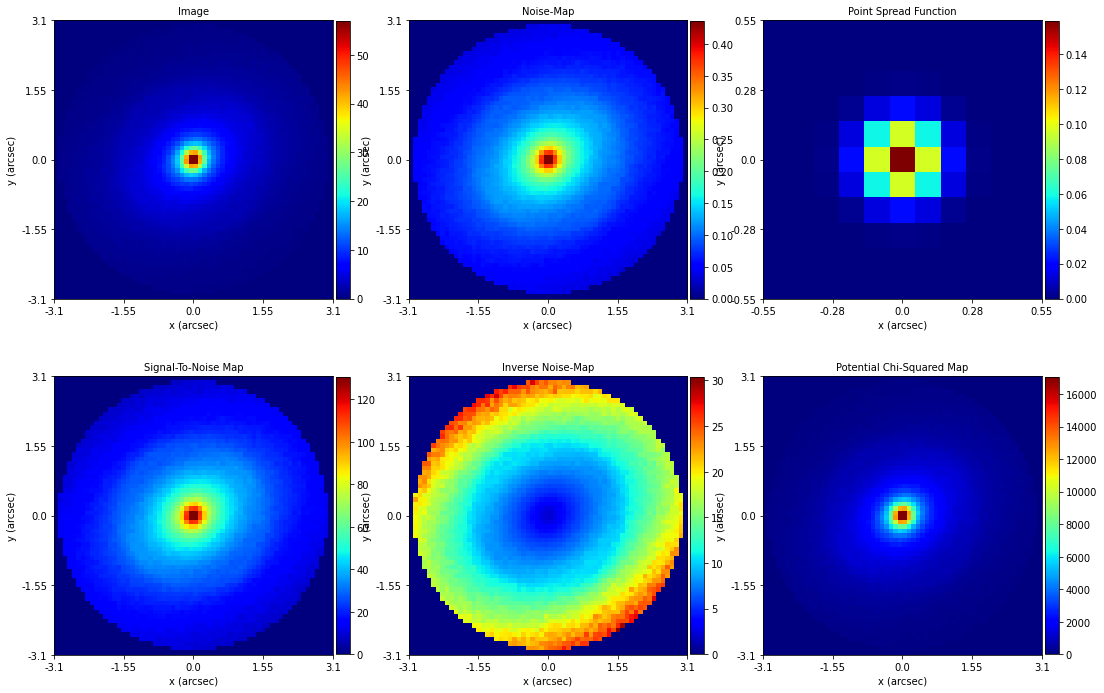

In [2]:
dataset_name = "light_sersic_exp__mass_mlr_nfw__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "pipelines", dataset_name)

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In this analysis, they are used to explicitly set the `mass_at_200` of the elliptical NFW dark matter profile, which is
a model parameter that is fitted for.

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__Model + Search + Analysis + Model-Fit (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's light is a parametric `EllSersic` bulge and `EllExponential` disk, the centres of 
 which are aligned [11 parameters].

 - The lens galaxy's mass and source galaxy are omitted.

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=11.

In [5]:
bulge = af.Model(al.lp.EllSersic)
disk = af.Model(al.lp.EllExponential)

bulge.centre = disk.centre

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, bulge=bulge, disk=disk)
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]_light[parametric]", nlive=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.75it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -637473.704 <    inf | logz: -637478.369 +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's light and stellar mass is an `EllSersic` bulge and `EllExponential` disk [Parameters 
 fixed to results of search 1].

 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` whose centre is aligned with the 
 `EllSersic` bulge and stellar mass model above [3 parameters].

 - The lens mass model also includes an `ExternalShear` [2 parameters].

 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

NOTES:

 - By using the fixed `bulge` and `disk` model from the result of search 1, we are assuming this is a sufficiently 
 accurate fit to the lens's light that it can reliably represent the stellar mass.

In [6]:
bulge = result_1.instance.galaxies.lens.bulge
disk = result_1.instance.galaxies.lens.disk

dark = af.Model(al.mp.EllNFWMCRLudlow)
dark.centre = bulge.centre
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = redshift_lens
dark.redshift_source = redshift_source

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=0.5,
            bulge=bulge,
            disk=disk,
            dark=af.Model(al.mp.EllNFW),
            shear=al.mp.ExternalShear,
        ),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]_light[fixed]_mass[light_dark]_source[parametric]",
    nlive=75,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 33.10it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.084]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 3)__

We use the results of searches 1 and 2 to create the lens model fitted in search 3, where:

 - The lens galaxy's light and stellar mass is a parametric `EllSersic` bulge and `EllExponential` disk 
 [8 parameters: priors initialized from search 1].

 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` whose centre is aligned with the 
 `EllSersic` bulge and stellar mass model above [3 parameters: priors initialized from search 2].

 - The lens mass model also includes an `ExternalShear` [2 parameters: priors initialized from search 2].

 - The source galaxy's light is a parametric `EllSersic` [7 parameters: priors initialized from search 2].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=22.

Notes:

 - This search attempts to address any issues there may have been with the bulge's stellar mass model.

In [7]:
bulge = result_1.model.galaxies.lens.bulge
disk = result_1.model.galaxies.lens.disk

dark = result_2.model.galaxies.lens.dark
dark.centre = bulge.centre

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=0.5,
            bulge=bulge,
            disk=disk,
            dark=dark,
            shear=result_2.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy, redshift=1.0, bulge=result_2.model.galaxies.source.bulge
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[3]_light[parametric]_mass[light_dark]_source[parametric]",
    nlive=100,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_3 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 28.55it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 4)__

We use the results of searches 3 to create the lens model fitted in search 4, where:

 - The lens galaxy's light and stellar mass is an `EllSersic` bulge and `EllExponential` 
 disk [Parameters fixed to results of search 3].

 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` [Parameters fixed to results of 
 search 3].

 - The lens mass model also includes an `ExternalShear` [Parameters fixed to results of search 3].

 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [2 parameters].

 - This pixelization is regularized using a `Constant` scheme [1 parameter]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

NOTES:

 - This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
 of the regularization scheme, before using these models to refit the lens mass model.

In [8]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            bulge=result_3.instance.galaxies.lens.bulge,
            disk=result_3.instance.galaxies.lens.disk,
            dark=result_3.instance.galaxies.lens.dark,
            shear=result_3.instance.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=al.pix.VoronoiMagnification,
            regularization=al.reg.Constant,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[4]_light[fixed]_mass[fixed]_source[inversion_initialization]",
    nlive=20,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_4 = search.fit(model=model, analysis=analysis)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
0it [00:00, ?it/s]/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 675:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
2it [00:03,  1.99s/it, +20 | bound: 0 | nc: 1 | ncall: 22 | eff(%): 100.000 | loglstar:   -inf < 520.344 <    inf | logz: 516.508 +/-    nan | dlogz:  1.099 >  0.029]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iter

__Model +  Search (Search 5)__

We use the results of searches 3 and 4 to create the lens model fitted in search 5, where:

 - The lens galaxy's light and stellar mass is an `EllSersic` bulge and `EllExponential` 
 disk [11 parameters: priors initialized from search 3].

 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` [8 parameters: priors initialized 
 from search 3].

The lens mass model also includes an `ExternalShear` [2 parameters: priors initialized from search 3].

 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [parameters fixed to results of search 4].

 - This pixelization is regularized using a `Constant` scheme [parameters fixed to results of search 4]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=19.

In [9]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            bulge=result_3.model.galaxies.lens.bulge,
            disk=result_3.model.galaxies.lens.disk,
            dark=result_3.model.galaxies.lens.dark,
            shear=result_3.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=result_4.instance.galaxies.source.pixelization,
            regularization=result_4.instance.galaxies.source.regularization,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[5]_light[parametric]_mass[light_dark]_source[inversion]",
    nlive=20,
)

__Positions + Analysis + Model-Fit (Search 5)__

We update the positions and positions threshold using the previous model-fitting result (as described 
 in `chaining/examples/parametric_to_inversion.py`) to remove unphysical solutions from the `Inversion` model-fitting.

In [10]:
settings_lens = al.SettingsLens(
    positions_threshold=result_4.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisImaging(
    dataset=imaging,
    settings_lens=settings_lens,
    positions=result_4.image_plane_multiple_image_positions,
)

result_5 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:388: UserWarning: Beware! Having `nlive <= 2 * ndim` is extremely risky!
  warnings.warn("Beware! Having `nlive <= 2 * ndim` is extremely risky!")
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  4.29it/s, +20 | bound: 0 | nc: 1 | ncall: 22 | eff(%): 100.000 | loglstar:   -inf < 685.085 <    inf | logz: 681.250 +/-    nan | dlogz:  1.099 >  0.029]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.